In [68]:
from lxml import etree
import os
from os import listdir
import pandas as pd
from IPython.display import display, HTML
from msgspec.json import decode

from torchvision.io import read_image
import matplotlib.pyplot as plt

In [69]:
class Defect:
    assemblyRevision = ''
    serialNumber = ''
    testerName = ''
    type = ''
    dataFolderName = ''
    indictmentType = ''
    repairOperator = ''
    repairStatus = ''
    designator = ''
    partId = ''
    pinId = ''

    def to_dict(self):
        res = {}
        res['assemblyRevision'] = self.assemblyRevision
        res['serialNumber'] = self.serialNumber
        res['testerName'] = self.testerName
        res['type'] = self.type
        res['dataFolderName'] = self.dataFolderName
        res['indictmentType'] = self.indictmentType
        res['repairOperator'] = self.repairOperator
        res['repairStatus'] = self.repairStatus
        res['designator'] = self.designator
        res['partId'] = self.partId
        res['pinId'] = self.pinId

        return res

In [70]:
def parse_file_for_defects(path, include_pin = True):
    root = etree.parse(path)
    ns = root.getroot().nsmap
    res = [] #Defect()
    serialNumber = root.getroot().find("ns1:BoardXML", ns).attrib.get('serialNumber')
    testerName = root.getroot().find("ns1:StationXML", ns).attrib.get('testerName')
    assemblyRevision = root.getroot().find("ns1:BoardXML", ns).attrib.get('assemblyRevision')
    dataFolderName = root.getroot().attrib.get('dataFolderName') 

    # TestXML = root.getroot().findall(".//ns1:TestXML", ns)
    TestXML = root.getroot().findall(".//ns1:TestXML", ns)
    for test in TestXML:
        name = test.attrib.get('name')
        IndictmentXML = test.findall(".//ns1:IndictmentXML", ns)
        PinXML = test.findall(".//ns1:PinXML", ns)
    
        for Indictment in IndictmentXML:
            tmp = Defect()
            tmp.assemblyRevision = assemblyRevision
            tmp.serialNumber = serialNumber
            tmp.testerName = testerName
            tmp.designator = name
            tmp.dataFolderName = dataFolderName
            tmp.type = 'IndictmentXML'
            tmp.indictmentType = Indictment.attrib.get('indictmentType')
            tmp.repairOperator = Indictment.find("ns1:RepairActionXML", ns).attrib.get('repairOperator')
            tmp.repairStatus = Indictment.find("ns1:RepairActionXML", ns).attrib.get('repairStatus')
            tmp.partId = Indictment.find("ns1:ComponentXML", ns).attrib.get('partId')
            res.append(tmp)

        if include_pin:
            partId = IndictmentXML[0].find("ns1:ComponentXML", ns).attrib.get('partId')
            repairOperator = IndictmentXML[0].find("ns1:RepairActionXML", ns).attrib.get('repairOperator')
            for pin in PinXML:
                repairStatus = pin.attrib.get('repairStatus')
                id = pin.attrib.get('id')
                PinIndictmentXML = pin.findall(".//ns1:PinIndictmentXML", ns)
                tmp.dataFolderName = dataFolderName

                for pinIndictment in PinIndictmentXML:
                    tmp = Defect()
                    tmp.assemblyRevision = assemblyRevision
                    tmp.serialNumber = serialNumber
                    tmp.testerName = testerName
                    tmp.designator = name
                    tmp.dataFolderName = dataFolderName
                    tmp.type = 'PinXML'
                    tmp.indictmentType = pinIndictment.attrib.get('indictmentType')
                    tmp.repairOperator = repairOperator
                    tmp.repairStatus = repairStatus
                    tmp.partId = partId
                    tmp.pinId = id
                    res.append(tmp)
        
    return res

In [71]:
def get_dataFolderName(path):
    root = etree.parse(path)
    dataFolderName = root.getroot().attrib.get('dataFolderName')
    return dataFolderName


def get_df_defects(file_path, include_pin):
    defects = []
    tmp = parse_file_for_defects(file_path, include_pin = include_pin)
    for t in tmp:
        defects.append(t.to_dict())

    df_defects = pd.DataFrame(defects)

    return df_defects


def get_img_df(img_folder):
    path_json = img_folder + 'json_data.json'

    with open(path_json, "rb") as f:
        data = decode(f.read())

    all_rows = data['post_ticket']['call_summary']['falsecall_refdes']
    all_rows.update(data['post_ticket']['call_summary']['truecall_refdes'])

    df_js = pd.DataFrame.from_dict(all_rows, orient='index')
    df_js.reset_index(inplace=True)
    df_js.rename(columns={'index': 'designator'}, inplace=True)
    df_js['img_folder'] = img_folder
    
    return df_js

In [5]:
XML_FILES_PATH = '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/'
PATH_IMAGES = '/media/ilya/My Passport/HSE/RAWData/img_files_may/2024/05/'

In [6]:
all_xml_files = listdir(XML_FILES_PATH)
all_xml_files_full = [XML_FILES_PATH + file for file in all_xml_files]
all_xml_files_full.sort(key=os.path.getmtime)
len(all_xml_files_full), all_xml_files_full[:5]

(6175,
 ['/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A44N2F08L#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625309000#PostRepair#1714625715000.xml',
  '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A440ZR01M#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625372000#PostRepair#1714625828000.xml',
  '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A44M9Z03A#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625487000#PostRepair#1714625868000.xml',
  '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A44M9Z034#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625564000#PostRepair#1714625903000.xml',
  '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y0VCA44J5Z005#MBDX86784004B_T#V510#D-SMT-AOI-41#1#1714625498000#PostRepair#1714625931000.xml'])

In [10]:
valid_xml_files = []
nones = 0

for file in all_xml_files_full:
    tmp = get_dataFolderName(file)
    if tmp != None:
        # print(tmp, PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json')
        if os.path.isfile(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json'):
            valid_xml_files.append(file)
        # valid_xml_files.append(file)
    else:
        nones += 1
    
len(valid_xml_files), nones, nones*100/len(valid_xml_files), nones + len(valid_xml_files)

(6173, 0, 0.0, 6173)

In [11]:
valid_xml_files[:3]

['/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A44N2F08L#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625309000#PostRepair#1714625715000.xml',
 '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A440ZR01M#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625372000#PostRepair#1714625828000.xml',
 '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_20/Y1O3A44M9Z03A#RSRPCI782005B_T#V510#D-SMT-AOI-51#1#1714625487000#PostRepair#1714625868000.xml']

In [12]:
list_df = []

for file_path in valid_xml_files:
    df_defects_tmp = get_df_defects(file_path, False)
    tmp = get_dataFolderName(file_path)
    df_img_tmp = get_img_df(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/')
    df_total = df_defects_tmp.merge(df_img_tmp, on='designator', how='inner')
    list_df.append(df_total)
    # list_df.append(df_defects_tmp)

df_total_pre = pd.concat(list_df)
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,143692,143692,143692,143692,143692,143692,143692,143692,143692,143692,143692,143692,143692,143692
unique,12,3657,3,1,6172,21,6,2,3345,402,1,278,111274,6172
top,MBDX86784004B_T,Y0VCA442MF0BD,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-05-08-08-27-09,BadJoint,Semen_O,False Call,1:j88,RC0402JR-070RP,,[BadJoint],noImage,/media/ilya/My Passport/HSE/RAWData/img_files_...
freq,80772,275,90303,143692,149,39554,39185,141682,2705,8280,143692,29315,6332,149


In [13]:
df_total_pre.loc[df_total_pre.repairStatus == 'False Call', 'repairStatus'] = 1
df_total_pre.loc[df_total_pre.repairStatus == 'Repaired', 'repairStatus'] = 0
df_total_pre.head()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
0,RSRPCI782005B_T,Y1O3A44N2F08L,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-51[@$@]2024-05-02-07-48-43,OCV Fail,Mihail_V,1,1:u1,SN74LVC1G17DCKR,,"[OCV Fail, BadJoint]",E_3161_1-u1.jpg,/media/ilya/My Passport/HSE/RAWData/img_files_...
1,RSRPCI782005B_T,Y1O3A44N2F08L,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-51[@$@]2024-05-02-07-48-43,BadJoint,Mihail_V,1,1:u1,SN74LVC1G17DCKR,,"[OCV Fail, BadJoint]",E_3161_1-u1.jpg,/media/ilya/My Passport/HSE/RAWData/img_files_...
2,RSRPCI782005B_T,Y1O3A44N2F08L,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-51[@$@]2024-05-02-07-48-43,Hor off,Mihail_V,1,1:j5,10156545-123Q100LF,,[Hor off],E_3161_1-j5.jpg,/media/ilya/My Passport/HSE/RAWData/img_files_...
3,RSRPCI782005B_T,Y1O3A44N2F08L,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-51[@$@]2024-05-02-07-48-43,OCV Fail,Mihail_V,1,2:u1,SN74LVC1G17DCKR,,[OCV Fail],E_3161_2-u1.jpg,/media/ilya/My Passport/HSE/RAWData/img_files_...
4,RSRPCI782005B_T,Y1O3A44N2F08L,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-51[@$@]2024-05-02-07-48-43,OCV Fail,Mihail_V,1,3:u1,SN74LVC1G17DCKR,,[OCV Fail],E_3161_3-u1.jpg,/media/ilya/My Passport/HSE/RAWData/img_files_...


In [14]:
df_total_pre['defect_image'].value_counts()

defect_image
noImage              6332
E_1426_1-u131.jpg       8
E_1497_1-u133.jpg       8
E_323_1-u246.jpg        7
E_1476_1-u109.jpg       7
                     ... 
E_726_1-d24.jpg         1
E_726_1-q59.jpg         1
E_726_1-u131.jpg        1
E_726_1-u133.jpg        1
E_3313_1-cr7.jpg        1
Name: count, Length: 111274, dtype: int64

In [15]:
df_total_pre = df_total_pre[df_total_pre.defect_image != 'noImage']
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,137360,137360,137360,137360,137360,137360,137360,137360,137360,137360,137360,137360,137360,137360
unique,12,3657,3,1,6172,21,6,2,3342,401,1,255,111273,6172
top,MBDX86784004B_T,Y0VCA442MF0BD,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-05-08-08-27-09,BadJoint,Semen_O,1,1:j88,RC0402JR-070RP,,[BadJoint],E_1497_1-u133.jpg,/media/ilya/My Passport/HSE/RAWData/img_files_...
freq,80772,275,90303,137360,149,39489,35966,135350,2705,8280,137360,29315,8,149


In [16]:
df_total_pre.to_csv('df_total_may_20_pre.csv', index=False)

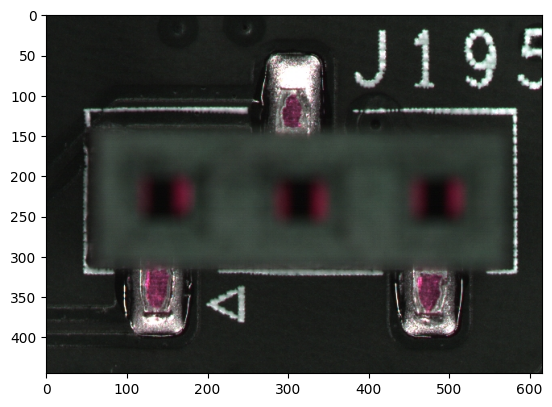

In [17]:
i = 55555
img_path = df_total_pre.iloc[i]['img_folder'] + df_total_pre.iloc[i]['defect_image']

img = read_image(img_path)
plt.imshow(  img.permute(1, 2, 0)  )

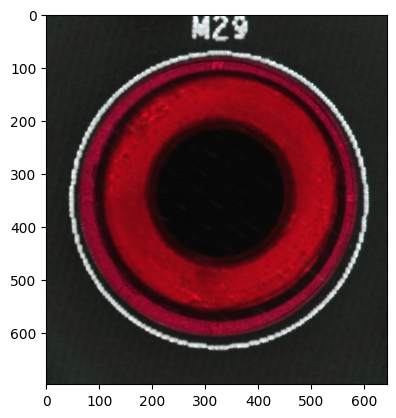

In [18]:
i = 555
img_path = df_total_pre.iloc[i]['img_folder'] + df_total_pre.iloc[i]['defect_image']

img = read_image(img_path)
plt.imshow(  img.permute(1, 2, 0)  )

In [67]:
df_total_true = df_total_pre.loc[df_total_pre['repairStatus'] == 0]
df_total_true['indictmentType'].count()

NameError: name 'df_total_pre' is not defined

In [21]:
df_total_true.to_csv('df_total_may_20_true.csv', index=False)

In [18]:
df_total_false = df_total_pre.loc[df_total_pre['repairStatus'] == 1]
df_total_false.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId
count,173719,173719,173719,173719,173719,173719,173719,173719,173719,173719,173719
unique,34,6681,3,1,9034,21,8,1,3578,558,1
top,MBDX86742001B_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,1,5:j1,110-10076-03,
freq,35789,485,112058,173719,287,67438,71207,173719,6709,31273,173719


In [50]:
65008 * 0.1 + 65008 * 0.75, 65008 * 0.75

(55256.8, 48756.0)

In [51]:
df_total_false_train = df_total_false[:48756]
df_total_false_val = df_total_false[48757:55257]
df_total_false_test = df_total_false[55258:]

In [19]:
df_total_true = df_total_pre.loc[df_total_pre['repairStatus'] == 0]
df_total_true.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId
count,2793,2793,2793,2793,2793,2793,2793,2793,2793,2793,2793
unique,26,1703,3,1,1905,19,8,1,670,189,1
top,MPLPCI781001C_T,Y1O1C44FYF251,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-51[@$@]2024-03-22-08-21-06,Missing,Semen_O,0,pc1898,SGA0000420Q,
freq,942,39,1463,2793,39,973,852,2793,600,600,2793


In [53]:
468 * 0.1 + 468 * 0.75, 468 * 0.75

(397.8, 351.0)

In [54]:
df_total_true_train = df_total_true[:350]
df_total_true_val = df_total_true[351:397]
df_total_true_test = df_total_true[398:]

In [55]:
df_total_train = pd.concat([df_total_false_train, df_total_true_train])
df_total_val = pd.concat([df_total_false_val, df_total_true_val])
df_total_test = pd.concat([df_total_false_test, df_total_true_test])

df_total_train.to_csv('df_total_train.csv', index=False)
df_total_val.to_csv('df_total_val.csv', index=False)
df_total_test.to_csv('df_total_test.csv', index=False)

In [2]:
import numpy as np
import pandas as pd
import os
import shutil

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import transforms


In [5]:
df_total_train2 = pd.read_csv('./df_total_train_shuffled_v1.csv')
df_total_train2_0 = df_total_train2.loc[df_total_train2['repairStatus'] == 0]

# train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
# train_y = (df_total_train['repairStatus']).tolist()

train_X_0_path = (df_total_train2_0['img_folder']).tolist()
train_X_0_imgname = (df_total_train2_0['defect_image']).tolist()

In [50]:
transfomation_random_choice = v2.RandomChoice([
    transforms.RandomHorizontalFlip(1),
    v2.RandomCrop((80, 80)),
    v2.RandomResizedCrop((220, 220)),
    v2.RandomVerticalFlip(1),
    v2.RandomErasing(),
    v2.RandomRotation(degrees=(0,45)),
    v2.ColorJitter(),
    v2.GaussianBlur(9),
    v2.RandomAdjustSharpness(1),
    v2.RandomAutocontrast(1),
    v2.RandomEqualize(1),
])

transfomation_random_order = v2.RandomOrder([
    transforms.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomErasing(),
    v2.ColorJitter(),
    v2.RandomAutocontrast(),
])

In [58]:
from torchvision.utils import save_image
from PIL import Image
# from torchvision.transforms.functional import to_tensor 

PATH_FOR_AUG = '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/aug_images/'
train_X_aug = []
train_y_aug = []

for idx, path in enumerate(train_X_0_path[:10]):
    pic = read_image(path + train_X_0_imgname[idx])

    for i in range(30):
        if i < 15:
            pic_trf = transfomation_random_choice(pic)
        if i >= 15:
            pic_trf = transfomation_random_order(pic).float()

        pic_trf = torchvision.transforms.functional.to_pil_image(pic_trf)
        pic_trf.save(PATH_FOR_AUG + str(i) + '_tsf_' + train_X_0_imgname[idx])
        # save_image(pic.float(), PATH_FOR_AUG + str(i) + '_tsf_' + train_X_0_imgname[idx])
        if os.path.getsize(PATH_FOR_AUG + str(i) + '_tsf_' + train_X_0_imgname[idx]) > 0:
            train_X_aug.append(str(i) + '_tsf_' + train_X_0_imgname[idx])
            train_y_aug.append(os.path.getsize(PATH_FOR_AUG + str(i) + '_tsf_' + train_X_0_imgname[idx]))

In [66]:
len(train_X_aug)
train_X_aug.index('0_tsf_E_1343_j87.jpg')
train_y_aug[58:62]
pic = read_image(PATH_FOR_AUG + '0_tsf_E_1343_j87.jpg')

In [ ]:
pd.DataFrame(train_X_aug).to_csv('train_X_aug.csv', index=False)
pd.DataFrame(train_y_aug).to_csv('train_y_aug.csv', index=False)

In [72]:
PATH_IMAGES = '/media/ilya/My Passport/HSE/RAWData/img_files_may/2024/05/'

In [92]:
XML_FILES_PATH = '/media/ilya/My Passport/HSE/RAWData/all_xml_files_may_29/'

all_xml_files = listdir(XML_FILES_PATH)
all_xml_files_full = [XML_FILES_PATH + file for file in all_xml_files]
all_xml_files_full.sort(key=os.path.getmtime)

valid_xml_files = []
nones = 0

for file in all_xml_files_full:
    tmp = get_dataFolderName(file)
    if tmp != None:
        # print(tmp, PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json')
        if os.path.isfile(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json'):
            valid_xml_files.append(file)
        # valid_xml_files.append(file)
    else:
        nones += 1

len(valid_xml_files), nones, nones*100/len(valid_xml_files), nones + len(valid_xml_files)

(220, 0, 0.0, 220)

In [93]:
list_df = []

for file_path in valid_xml_files:
    df_defects_tmp = get_df_defects(file_path, False)
    tmp = get_dataFolderName(file_path)
    df_img_tmp = get_img_df(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/')
    df_total = df_defects_tmp.merge(df_img_tmp, on='designator', how='inner')
    list_df.append(df_total)
    # list_df.append(df_defects_tmp)

df_total_pre = pd.concat(list_df)
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,5521,5521,5521,5521,5521,5521,5521,5521,5521,5521,5521,5521,5521,5521
unique,3,219,2,1,220,19,5,2,367,171,1,82,3667,220
top,DEMB0_LA-G437P_MB_A01_T,Y2G9A44MDJ02K,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-11[@$@]2024-05-29-08-57-33,BadJoint,Semen_O,False Call,1:jp197,SB00001F70Q,,[BadJoint],noImage,/media/ilya/My Passport/HSE/RAWData/img_files_...
freq,4238,46,4238,5521,46,1183,4166,5466,399,749,5521,767,653,46


In [94]:
df_total_pre.loc[df_total_pre.repairStatus == 'False Call', 'repairStatus'] = 1
df_total_pre.loc[df_total_pre.repairStatus == 'Repaired', 'repairStatus'] = 0
df_total_pre = df_total_pre[df_total_pre.defect_image != 'noImage']

df_total_pre.to_csv('all_xml_files_may_29.csv', index=False)

In [ ]:
df_total_test = pd.read_csv('./eda/all_xml_files_may_22.csv')

resolution = (240, 240)  #(384, 384)

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model_path = '.'
model = torch.load(f'{model_path}/EfV2L_noaug_10e_base_shfld_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

accuracy_recall_precision(model, test_dataloader)

In [ ]:
df_total_test['modelPredict'] = get_predict(model, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

In [ ]:
df_total_train = pd.read_csv('./eda/all_xml_files_may_21.csv')
df_total_test = pd.read_csv('./eda/all_xml_files_may_22.csv')

resolution = (240, 240)  #(384, 384)

train_transforms = transforms.Compose([
    transforms.Resize(resolution),
    # transforms.RandomHorizontalFlip(),
    # v2.RandomCrop(size=(224, 224)),
    # v2.RandomResizedCrop(size=(32, 32)),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.equalizer = v2.RandomEqualize(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.ColorJitter(),
    # transforms.ToTensor(),
    # transforms.RandAugment(num_ops = 2, magnitude = 9),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # transforms.RandomErasing(),
])

val_transforms = transforms.Compose([
    transforms.Resize(resolution),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()
val_X = train_X[:50]
val_y = train_y[:50]
test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

train_dataset = image(train_X, train_y, train_transforms)
val_dataset = image(val_X, val_y, val_transforms)
test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
len(train_X)

In [ ]:
#
model_path = '.'
model21 = torch.load(f'{model_path}/EfV2L_noaug_10e_base_shfld_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model21 = model21.to(device)

weights = torch.FloatTensor([0.95, 0.05]).to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights)
# оптимизатор
optimizer = torch.optim.SGD(model21.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [ ]:
train_model(model21, loss, optimizer, num_epochs=num_epochs, device=device)

In [ ]:
accuracy_recall_precision(model12_1, test_dataloader)

In [ ]:
df_total_test['modelPredict'] = get_predict(model12_1, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

In [ ]:
torch.save(model21, "./EfV2L_model21.pt")